# Pix2Pix Tutorial

This is a simple front to end tutorial for Pix2Pix: Image-to-image translation with a conditional GAN.

**Name**: Avneesh Mishra (GitHub: [@TheProjectsGuy](https://github.com/TheProjectsGuy)) <br>
**Roll No**: `2021701032` <br>
**Course**: `Computer Vision - CS7.505` <br>
**Team**: Team Zen



This tutorial is inspired by the following sources
- TensorFlow [Generative network Tutorial on Pix2Pix](https://www.tensorflow.org/tutorials/generative/pix2pix)
- Image-to-image translation with conditional GAN paper
    - CVPR 2017 paper

        ```txt
        Isola, Phillip, et al. "Image-to-image translation with conditional adversarial networks." Proceedings of the IEEE conference on computer vision and pattern recognition. 2017.
        ```

        arXiv - with model and training information in supplementary material: [arXiv:1611.07004](https://arxiv.org/abs/1611.07004)
- Official GitHub repository: [phillipi/pix2pix](https://github.com/phillipi/pix2pix)

The aim is to implement, train and test the Pix2Pix GAN from scratch.


In [1]:
# Include everything
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

# Utilities
import os
import glob


In [2]:
# Sanity check for TensorFlow
print(f"TensorFlow version: {tf.__version__}")
print(f"Devices: {tf.config.list_physical_devices()}")

TensorFlow version: 2.8.0
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Dataset

Loading the dataset, and inspecting samples from it.

Before starting, do the following

1. Download the dataset from [efrosgans](http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/). 
2. Extract a segment into a dataset directory. The segment should have train and validation folders (which contain images). Each file (zip) in the above link is a segment.
3. Set the variables below accordingly.


In [3]:
# Dataset path
dataset_dir = "~/Downloads/Datasets/pix2pix"    # Folder containing zip
dataset_seg = "cityscapes"    # Should be extracted zip folder

# Ensure folder exists and has data
data_dir = os.path.realpath(f"{os.path.expanduser(dataset_dir)}/{dataset_seg}")
assert os.path.isdir(data_dir), f"Check directory: {data_dir}"
# Load all file names
train_fnames = glob.glob(f"{data_dir}/train/*.jpg")
if os.path.isdir(f"{data_dir}/test"):
    test_fnames = glob.glob(f"{data_dir}/test/*.jpg")
elif os.path.isdir(f"{data_dir}/val"):
    test_fnames = glob.glob(f"{data_dir}/val/*.jpg")
else:
    raise FileNotFoundError("Test (or validation) set not found")
print(f"Found {len(train_fnames)} images in '{dataset_seg}'")

Found 2975 images in 'cityscapes'


Inspect a data sample

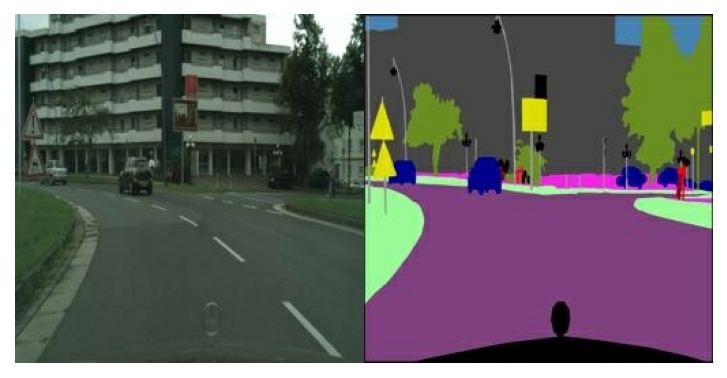

In [4]:
img = tf.io.read_file(train_fnames[0])  # Training sample
img = tf.io.decode_jpeg(img)    # A H, 2W, 3 image (2W because hstack)
# Show image
plt.figure(dpi=150)
plt.imshow(img)
plt.axis('off')
plt.show()

The images are horizontally stacked. Let's convert an image (pair) to separate images (left is target output of generator and right is input to generator)

> **Note**: Use `tf.shape` which allows adding it to the graph, do not use `img.shape` as it won't work in TensorFlow Dataset later.

In [5]:
# Split image, return prediction, input images
def cut_image(img_fname: str):
    # Read and decode
    img = tf.io.decode_jpeg(tf.io.read_file(img_fname))
    # Split image (half width cut)
    w = tf.shape(img)[1]//2 # Cut point
    pred_img = img[:, :w]   # Prediction (first part)
    in_img = img[:, w:]     # Input image (second part)
    # Covert to float32
    pred_img = tf.cast(pred_img, tf.float32)
    in_img = tf.cast(in_img, tf.float32)
    return pred_img, in_img

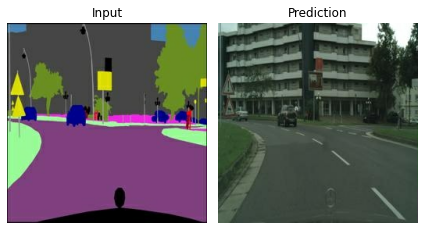

In [6]:
# View a separated image pair
pred_img, in_img = cut_image(train_fnames[0])
# Plot images
plt.figure()
plt.subplot(1, 2, 1)
plt.title("Input")
plt.imshow(in_img/255)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Prediction") # To be generated
plt.imshow(pred_img/255)
plt.axis('off')
plt.tight_layout()
plt.show()

### Data Augmentation

Data augmentation defined in the paper to increase/augment training data


In [7]:
# ======= Preferences =======
BUFFER_SIZE = len(train_fnames)  # Number of data samples in training
BATCH_SIZE = 1      # Batch size = 1 in paper
# Image size
IMG_HEIGHT, IMG_WIDTH = in_img.shape[0:2]
IMGR_HEIGHT, IMGR_WIDTH = 286, 286  # Resize to this (before random crops)

#### Random Jitter

In section `6.2: Training details` of arXiv paper, random jitter is applied to $256 \times 256$ image by first resizing to $286 \times 286$ and then taking random crops of $256 \times 256$ from this image. There is also random mirroring applied.


In [8]:
# Resize image
@tf.function()
def resize(in_img, pred_img, to_height, to_width):
    # Input to generator
    in_img = tf.image.resize(in_img, (to_height, to_width), 
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # Prediction (for generator)
    pred_img = tf.image.resize(pred_img, (to_height, to_width),
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # Return both
    return in_img, pred_img

In [9]:
# Normalize images
@tf.function()
def norm_imgs(in_img, pred_img):
    # Input image (to the generator)
    in_img = (in_img/127.5) - 1
    # Output/prediction image (for the generator)
    pred_img = (pred_img/127.5) - 1
    return in_img, pred_img

Main random jitter function

In [10]:
# Apply random crops to the image
@tf.function()
def random_crop(in_img, pred_img):
    both_imgs = tf.stack([in_img, pred_img], axis=0)
    cropped_imgs = tf.image.random_crop(both_imgs, 
        size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
    return cropped_imgs[0], cropped_imgs[1]

# Apply random jitter to an image (resize, crop & mirror)
@tf.function()
def apply_jitter(in_img, pred_img):
    # Resize image to larger size
    inimg, predimg = resize(in_img, pred_img, 
        IMGR_HEIGHT, IMGR_WIDTH)
    # Apply a random crop
    in_cimg, pred_cimg = random_crop(inimg, predimg)
    # Apply random mirroring
    both_imgs = tf.stack([in_cimg, pred_cimg])  # [2, H, W, 3]
    both_fimgs = tf.image.random_flip_left_right(both_imgs)
    in_fimg, pred_fimg = both_fimgs[0], both_fimgs[1]   # Randomly flipped images
    # Return both images (input to generator, prediction for generator)
    return in_fimg, pred_fimg


Seeing the jitter

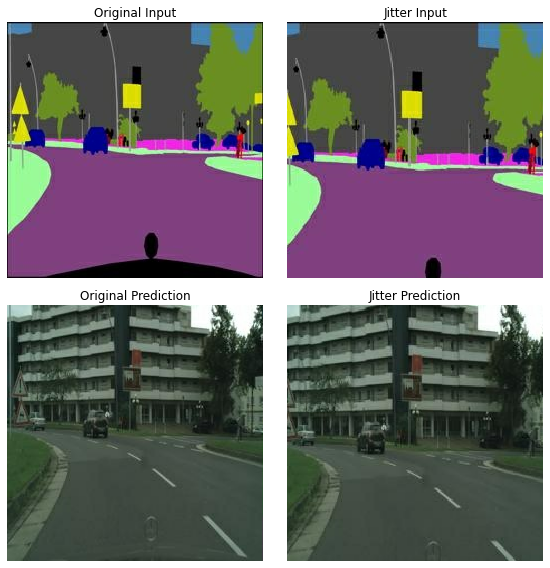

In [11]:
in_jimg, pred_jimg = apply_jitter(in_img, pred_img)
# Show the images
plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.title("Original Input")
plt.imshow(in_img/255)
plt.axis('off')
plt.subplot(2, 2, 2)
plt.title("Jitter Input")
plt.imshow(in_jimg/255)
plt.axis('off')
plt.subplot(2, 2, 3)
plt.title("Original Prediction")
plt.imshow(pred_img/255)
plt.axis('off')
plt.subplot(2, 2, 4)
plt.title("Jitter Prediction")
plt.imshow(pred_jimg/255)
plt.axis('off')
plt.tight_layout()
plt.show()

#### Image Loading functions

Pipelines used by training and testing. Convert image filename to the image which will be taken by the models.


In [12]:
# Training pipeline
def create_img_pipeline(training=True):
    # Main pipeline to be returned
    def preprocess_data(img_fname):
        # Load images from file name
        in_img, pred_img = cut_image(img_fname)
        # Training or testing pipeline
        if training:
            # Apply random jitter (for training data augmentation)
            in_img, pred_img = apply_jitter(in_img, pred_img)
        else:   # Testing is only resizing (hopefully the same size)
            in_img, pred_img = resize(in_img, pred_img, IMG_HEIGHT, IMG_WIDTH)
        # Normalize the image
        in_img, pred_img = norm_imgs(in_img, pred_img)
        # Return the images (input and prediction/target - for generator)
        return in_img, pred_img
    # Return function that does all preprocessing to data
    return preprocess_data


#### Input Pipeline

Pipelines for feeding data (applying all preprocessing).

Some references:
- TensorFlow guide on [tf.data](https://www.tensorflow.org/guide/data)
- [Dataset class](https://www.tensorflow.org/api_docs/python/tf/data/Dataset): You may also want to see [iterator](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#__iter__), and [get_next for Iterator](https://www.tensorflow.org/api_docs/python/tf/data/Iterator#get_next)


For training

In [13]:
# Compile a training Dataset
training_dataset = tf.data.Dataset.from_tensor_slices(train_fnames)
training_dataset = training_dataset.map(create_img_pipeline(training=True), 
    num_parallel_calls=tf.data.AUTOTUNE)    # -> in, pred image
# Shuffle entire buffer
training_dataset = training_dataset.shuffle(BUFFER_SIZE)
# Split into batches
training_dataset = training_dataset.batch(BATCH_SIZE)

For testing

In [14]:
# Compile a testing Dataset
testing_dataset = tf.data.Dataset.from_tensor_slices(test_fnames)
testing_dataset = testing_dataset.map(create_img_pipeline(training=False),
    num_parallel_calls=tf.data.AUTOTUNE)
testing_dataset = testing_dataset.batch(BATCH_SIZE)

We now have the TensorFlow Dataset objects ready to feed data to the network.

In [15]:
# A cell for rough work!

## Networks

The networks described in the pix2pix paper. The generator comprises of an encoder and a decoder (or a U-Net like architecture). The discriminator is CNN. Together they make the GAN for Pix2Pix.


### Utility functions

Some helper code for what's to come

In [16]:
# Properties of image
IN_CHANNELS = int(tf.shape(in_img)[2])      # Input image depth
OUT_CHANNELS = int(tf.shape(pred_img)[2])   # Output image depth

In [17]:
# Some more imports to make life easier
from tensorflow import initializers as tfinit
from tensorflow import keras

A downsample layer which will be used by the encoder (of the generator) and the discriminator

In [18]:
# Downsample layer (Conv + BN + ReLu)
def downsample_layer(no_filters, kernel_size, conv_strides=2, padding='same',
        use_bn=True, lrelu_alpha=0.3, k_bias=True):
    # Initializer as in arxiv paper (section 6.2)
    kinit = tfinit.RandomNormal(mean=0.0, stddev=0.02)
    step_layers = keras.Sequential()    # Container for layers
    # Convolution
    step_layers.add(keras.layers.Conv2D(no_filters, kernel_size, conv_strides, 
        padding, kernel_initializer=kinit, use_bias=k_bias))
    # Use batch normalization
    if use_bn:
        step_layers.add(keras.layers.BatchNormalization())
    # ReLU layer
    step_layers.add(keras.layers.LeakyReLU(alpha=lrelu_alpha))
    return step_layers  # All layers for downsampling

An upsample layer which will be used by the decoder (of the generator)

In [19]:
# Upsampling layer (Upconv + BN + ReLU)
def upsample_layer(no_filters, kernel_size, upconv_strides=2, padding='same',
        use_bn=True, use_dpo=True, lrelu_alpha=0.3, k_bias=True):
    # Initializer as in arxiv paper (section 6.2)
    kinit = tfinit.RandomNormal(mean=0.0, stddev=0.02)
    step_layers = keras.Sequential()    # Container for layers
    # Up-convolution
    step_layers.add(keras.layers.Conv2DTranspose(no_filters, kernel_size, 
        upconv_strides, padding='same', use_bias=k_bias,
        kernel_initializer=kinit))
    # Use batch normalization
    if use_bn:
        step_layers.add(keras.layers.BatchNormalization())
    # Use dropout
    if use_dpo:
        step_layers.add(keras.layers.Dropout(0.5))
    # ReLU layer
    step_layers.add(keras.layers.LeakyReLU(alpha=lrelu_alpha))
    return step_layers

Testing the upsample and downsample layers

In [20]:
# Testing layers through a test image
test_img = tf.constant(np.random.rand(1, *in_img.shape))
# Downsample
down_model = downsample_layer(3, 4)
down_result = down_model(test_img)
print(f"Downsample: {test_img.shape} -> {down_result.shape}")
# Upsample
up_model = upsample_layer(3, 4)
up_result = up_model(down_result)
print(f"Upsample: {down_result.shape} -> {up_result.shape}")

Downsample: (1, 256, 256, 3) -> (1, 128, 128, 3)
Upsample: (1, 128, 128, 3) -> (1, 256, 256, 3)


### Generator

The Generator is a modified version of [U-Net][u-net-paper]. Contains an encoder and decoder.


**U-Net Paper**: `Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "U-net: Convolutional networks for biomedical image segmentation." International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.`

[u-net-paper]: https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28


In [26]:
# Create a Generator model
"""
    enc_ks:   Kernel strides for encoder
    enc_depths:     The number of kernels per convolution (downsample) layer
    dec_ks:     Kernel strides for decoder
    dec_depths:     The number of kernels per convolution (upsample) layer
    dec_dropouts:   The droupout conditions for the decoder layers
"""
def GeneratorModel(enc_ks=4, enc_depths=[64, 128, 256, *(5*[512])],
        dec_ks=4, dec_depths=[*(4*[512]), 256, 128, 64], 
        dec_dropouts=[*(3*[True]), *(4*[False])]):
    # Input placeholder (not including batch axis)
    batch_in = keras.Input(shape=[IMG_HEIGHT, IMG_WIDTH, IN_CHANNELS])
    # Encoder is downsampling
    encoder_layers = []
    # First layer (with no batch normalization - Sec. 6.1.1 arxiv paper)
    encoder_layers.append(downsample_layer(enc_depths[0], enc_ks, use_bn=False, 
        lrelu_alpha=0.2))
    # Add remaining layers with batch normalization
    for i in range(1, len(enc_depths)):
        encoder_layers.append(downsample_layer(enc_depths[i], enc_ks, 
            lrelu_alpha=0.2))
    # Decoder is upsampling
    decoder_layers = []
    # Add all layers to decoder
    for i in range(len(dec_depths)):
        decoder_layers.append(upsample_layer(dec_depths[i], dec_ks, 
            use_dpo=dec_dropouts[i], lrelu_alpha=0.0))
    # Last layer for convolution (upsample from decoder to out_img)
    last_layer = keras.layers.Conv2DTranspose(OUT_CHANNELS, dec_ks, 2, 
        padding='same', activation=keras.activations.tanh,
        kernel_initializer=tfinit.RandomNormal(mean=0.0, stddev=0.02))
    # ===== Main traversal of inputs =====
    x = batch_in
    cache_skips = []    # Cache outputs for skip connections
    # Downsampling through the encoder model
    for ed in encoder_layers:
        x = ed(x)   # Pass through layer
        cache_skips.append(x)   # Cache output
    # Flip the skip connections (latest output is the first skip to decoder)
    cache_skips = reversed(cache_skips[:-1])    # Last output is 1x1x(Depth)
    # Upsampling through the decoder model
    for du, skip in zip(decoder_layers, cache_skips):
        x = du(x)   # Pass through layer
        x = tf.keras.layers.Concatenate()([x, skip])
    # Through the last layer
    x = last_layer(x)
    # Final model
    gen_model = keras.Model(inputs=batch_in, outputs=x)
    return gen_model    # Generator model


Testing the U-Net generator

In [27]:
test_img = tf.constant(
    np.random.rand(BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, IN_CHANNELS))
gen_model = GeneratorModel()
out_img = gen_model(test_img)
print(f"Generator shape: {test_img.shape} -> {out_img.shape}")

Generator shape: (1, 256, 256, 3) -> (1, 256, 256, 3)


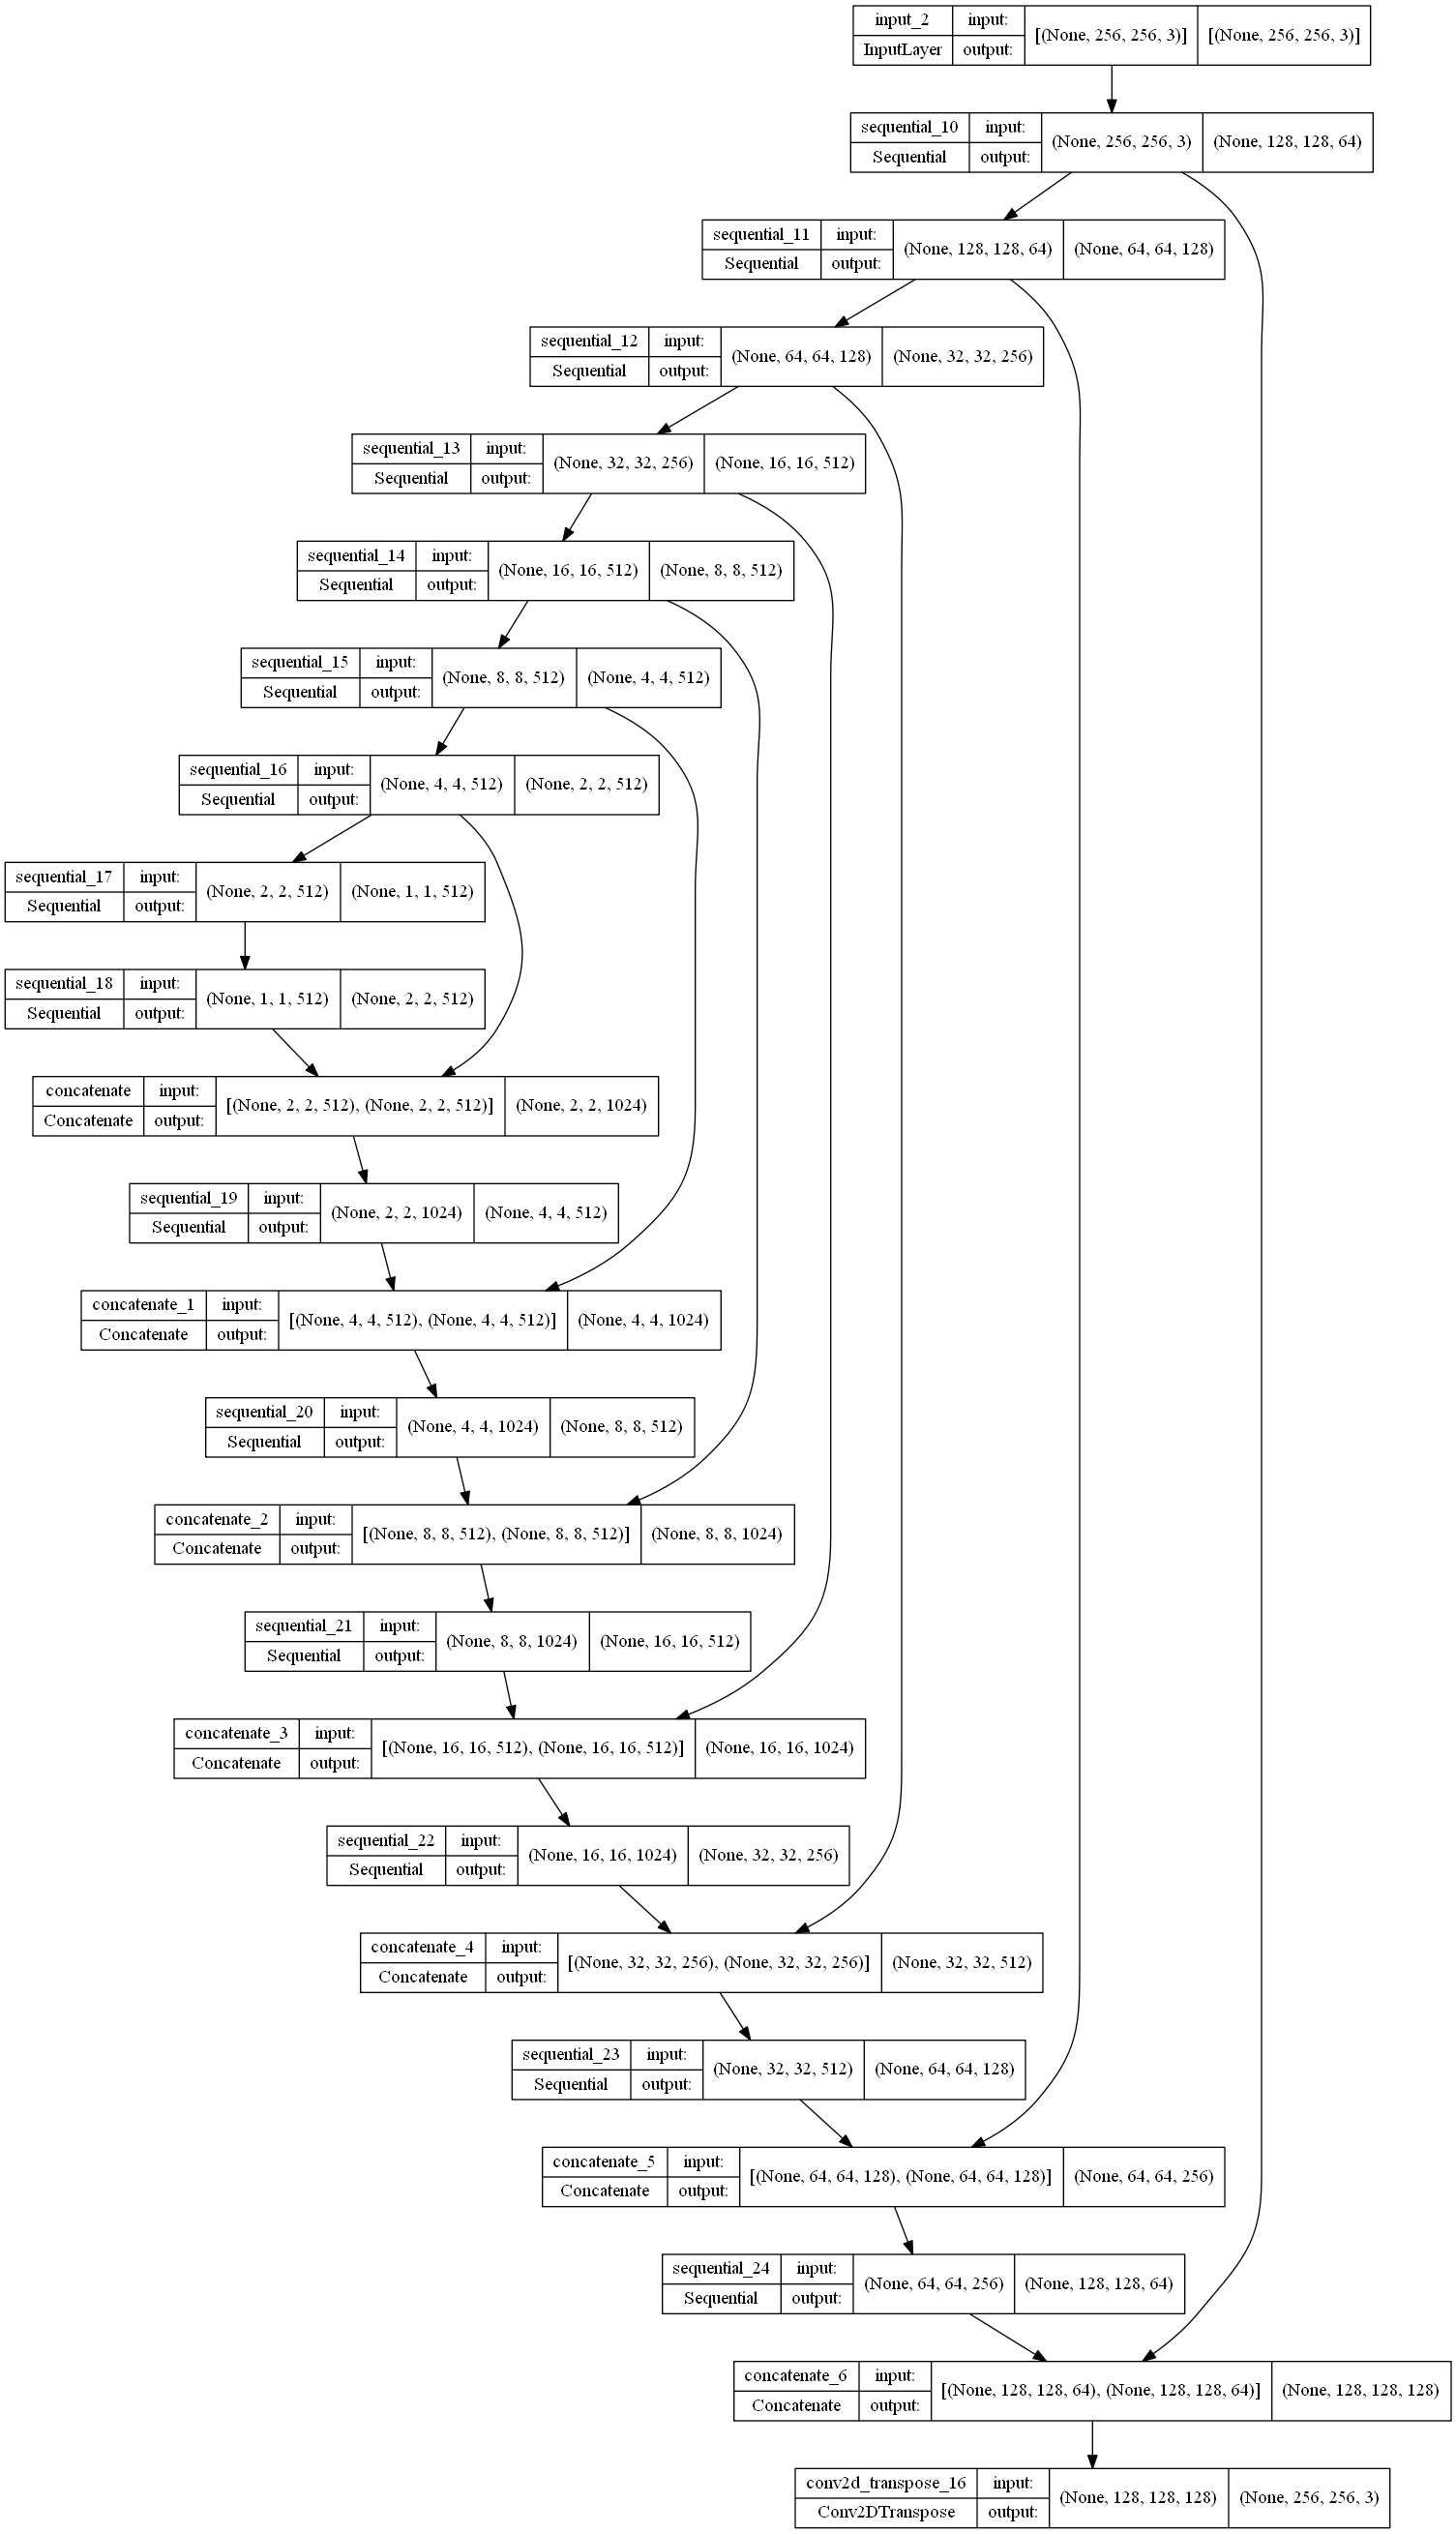

In [30]:
# Show the generator model
keras.utils.plot_model(gen_model, show_shapes=True)
# gen_model.summary(expand_nested=True)

### Discriminator

The Discriminator architectures are described in section 6.1.2 (in the arXiv paper). The discriminator is applied as patches (fully convolution).

This is a simple CNN

In [111]:
# Create a Discriminator model
def DiscriminatorModel():
    # Initializer
    kinit = tfinit.RandomNormal(mean=0.0, stddev=0.02)
    # Two inputs
    in_img = tf.keras.Input(shape=[IMG_HEIGHT, IMG_WIDTH, IN_CHANNELS],
        name="input_img")       # Input in data
    out_img = tf.keras.Input(shape=[IMG_HEIGHT, IMG_WIDTH, IN_CHANNELS],
        name="pred_img_data")   # Prediction (target/true out) in data
    # Downsampling convolutions (sequential model(s))
    seq_model = keras.Sequential()
    seq_model.add(downsample_layer(64, 4, use_bn=False, lrelu_alpha=0.2))
    seq_model.add(downsample_layer(128, 4, lrelu_alpha=0.2))
    seq_model.add(downsample_layer(256, 4, lrelu_alpha=0.2))

    # seq_model.add(downsample_layer(512, 4, lrelu_alpha=0.2))

    # seq_model.add(keras.layers.ZeroPadding2D())
    # seq_model.add(keras.layers.Conv2D(512, 4, 
    #     kernel_initializer=kinit))
    # seq_model.add(keras.layers.BatchNormalization())
    # seq_model.add(keras.layers.LeakyReLU(alpha=0.02))
    # seq_model.add(keras.layers.ZeroPadding2D())
    # seq_model.add(keras.layers.Conv2D(1, 4,
    #     kernel_initializer=kinit))

    seq_model.add(keras.layers.ZeroPadding2D())
    seq_model.add(downsample_layer(512, 4, 1, 'valid', lrelu_alpha=0.2))
    seq_model.add(keras.layers.ZeroPadding2D())
    seq_model.add(downsample_layer(1, 4, 1, 'valid', use_bn=False))
    # Use any of the sequential models above

    # ====== Main data flow ======
    # Concatenate the images (channel-wise)
    x = keras.layers.Concatenate()([in_img, out_img])
    x = seq_model(x)
    disc_model = keras.Model(inputs=[in_img, out_img], outputs=x)
    return disc_model

Testing the discriminator

In [117]:
a = tf.constant(np.random.rand(1, 256, 256, 3))
b = tf.constant(np.random.rand(1, 256, 256, 3))
disc_model = DiscriminatorModel()
out_img = disc_model([a, b])
print(f"Input shapes: {a.shape} -> {out_img.shape}")

Input shapes: (1, 256, 256, 3) -> (1, 30, 30, 1)


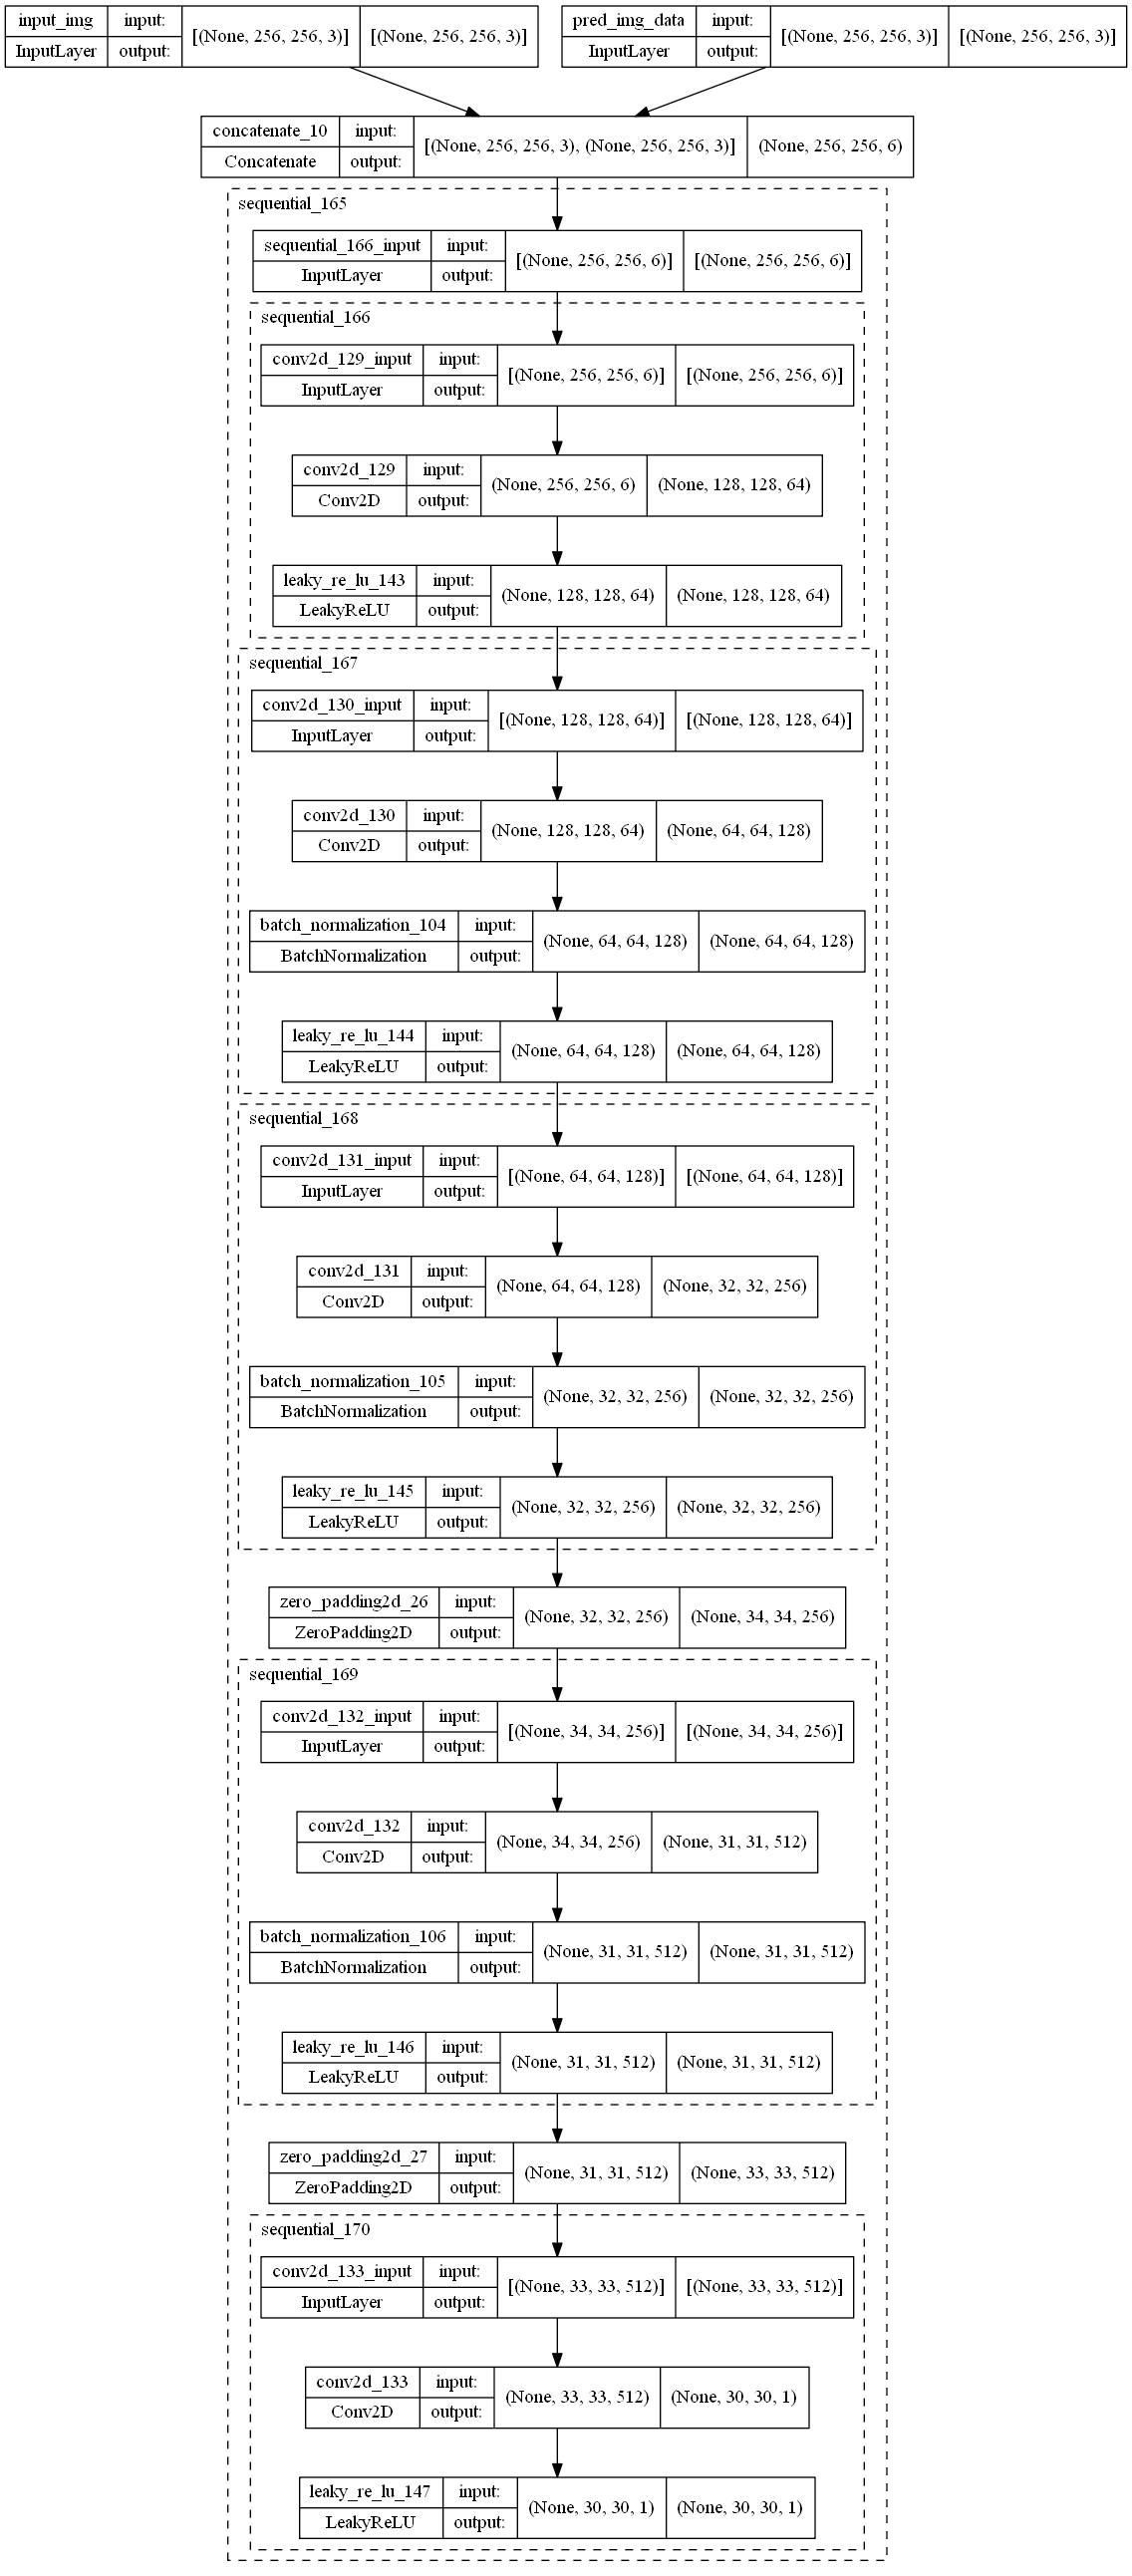

In [120]:
keras.utils.plot_model(disc_model, show_shapes=True, expand_nested=True)

The models are now ready to be used. We only need to train them (optimize over a loss function).

## Loss Function

The loss functions stated in the Pix2Pix paper

### Theory

Some theory on loss functions of GANs

**Paper**: `Goodfellow, Ian, et al. "Generative adversarial nets." Advances in neural information processing systems 27 (2014).`

**arXiv**: [arXiv:1406.2661](https://arxiv.org/abs/1406.2661). Also featured [in ACM](https://dl.acm.org/doi/10.1145/3422622)

A Generative Adversarial Network (GAN) contains a generator and a discriminator. Both compete and train each other. The training data contains pairs $x, y$ where we aim to learn $y$ from $x$.

The task of the _generator_ $G$ to take an input $x$ and generate an output $G(x)$. The task of the discriminator is to distinguish between $y$ and $G(x)$. 
If the discriminator gets the input $x$, then it is conditioned and such a GAN is called a **conditional** GAN, else it is an **unconditional** GAN.

The loss function is given by

$$
\mathcal{L}_{\textup{cGAN}} (G, D) = 
    \mathbb{E}_{x,y} \left [ \log \left ( D(x, y) \right ) \right ] 
  + \mathbb{E}_{x,z} \left [ \log \left ( 1 - D(x, G(x, z)) \right ) \right ]
$$

Where $\mathbb{E}_{x,y} [\cdot]$ and $\mathbb{E}_{x,z} [\cdot]$ are [expected values](https://en.wikipedia.org/wiki/Expected_value#Definition) over the domains (in the underscript). Here, $G$ tries to minimize this objective, and $D$ tries to maximize it. Also note that $D(\cdot, \cdot)$ gives a probability (0 to 1).


#### Parts of minimization

$G$ cannot minimize $\mathbb{E}_{x,y} \left [ \log \left ( D(x, y) \right ) \right ]$ (as it doesn't contain $G$ function), but it can minimize $\mathbb{E}_{x,z} \left [ \log \left ( 1 - D(x, G(x, z)) \right ) \right ]$.
